In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.api as sm
from difflib import get_close_matches

In [88]:
# Standings data (the CSV you shared)
standings = pd.read_csv("futball_21_25.csv")

# Sofifa data (FIFA ratings)
sofifa = pd.read_csv("sofifa.csv")

#### Fixing Team Mapping

In [89]:
def extract_team(team_contract):
    """Get team name from 'Team & Contract' (before newline)."""
    if isinstance(team_contract, str):
        return team_contract.split("\n")[0].strip()
    return None

sofifa["team_name"] = sofifa["Team & Contract"].apply(extract_team)


# Pre-processing
def extract_team(team_contract):
    if isinstance(team_contract, str):
        return team_contract.split("\n")[0].strip()
    return None
sofifa["team_name"] = sofifa["Team & Contract"].apply(extract_team)

def normalize_team_name(name):
    if not isinstance(name, str): return None

    # 1. Basic Cleaning FIRST (Lowercase, remove dots/dashes/extra spaces)
    s = name.lower()
    s = s.replace("-", " ").replace(".", " ")
    s = re.sub(r"\s+", " ", s).strip()
    
    manual_map = {
        "1899 hoffenheim": "tsg 1899 hoffenheim",
        "1 fc union berlin": "1 union berlin",
        "ac ajaccio": "ajaccio",
        "ac monza": "monza",
        "ac pisa 1909": "pisa",
        "acf fiorentina": "fiorentina",
        "ajaccio": "ajaccio",
        "alaves": "deportivo alavés",
        "almeria": "ud almería",
        "angers": "angers sco",
        "arminia bielefeld": "dsc arminia bielefeld",
        "as roma": "roma",
        "atalanta bc": "atalanta",
        "atletico de madrid": "atlético madrid",
        "atletico madrid": "atlético madrid",
        "atlético de madrid": "atlético madrid",
        "auxerre": "aj auxerre",
        "bayer leverkusen": "bayer 04 leverkusen",
        "bayern munich": "bayern münchen",
        "bologna 1909": "bologna",
        "bordeaux": "girondins de bordeaux",
        "borussia monchengladbach": "borussia mönchengladbach",
        "bournemouth": "afc bournemouth",
        "brighton": "brighton & hove albion",
        "cadiz": "cádiz",
        "cagliari calcio": "cagliari",
        "celta vigo": "rc celta",
        "clermont foot": "clermont foot 63",
        "como 1907": "como",
        "espanyol": "rcd espanyol",
        "frosinone calcio": "frosinone",
        "fsv mainz 05": "1 fsv mainz 05",
        "hertha berlin": "hertha bsc",
        "inter milan": "inter",
        "internazionale milano": "inter",
        "koln": "1 köln",
        "1 fc koln": "1 köln",
        "leeds": "leeds united",
        "leicester": "leicester city",
        "lens": "rc lens",
        "levante": "levante ud",
        "lille": "lille osc",
        "luton town": "luton town",
        "lyon": "olympique lyonnais",
        "mallorca": "rcd mallorca",
        "marseille": "olympique de marseille",
        "monaco": "as monaco",
        "montpellier": "montpellier hsc",
        "newcastle": "newcastle united",
        "nice": "ogc nice",
        "norwich": "norwich city",
        "osasuna": "ca osasuna",
        "parma calcio 1913": "parma",
        "racing de lens": "rc lens",
        "rayo vallecano de madrid": "rayo vallecano",
        "rc celta de vigo": "rc celta",
        "rcd espanyol de barcelona": "rcd espanyol",
        "real betis": "real betis balompié",
        "real sociedad de fútbol": "real sociedad",
        "reims": "stade de reims",
        "rennes": "stade rennais",
        "saint etienne": "as saint étienne",
        "salernitana": "us salernitana 1919",
        "spvgg greuther furth": "spvgg greuther fürth",
        "ss lazio": "lazio",
        "ssc napoli": "napoli",
        "st pauli 1910": "st pauli",
        "stade rennais 1901": "stade rennais",
        "strasbourg": "rc strasbourg alsace",
        "sunderland afc": "sunderland",
        "tottenham": "tottenham hotspur",
        "udinese calcio": "udinese",
        "union berlin": "1 fc union berlin",
        "us cremonese": "cremonese",
        "us lecce": "lecce",
        "us sassuolo calcio": "sassuolo",
        "valladolid": "real valladolid",
        "verona": "hellas verona",
        "vfl bochum": "vfl bochum 1848",
        "werder bremen": "sv werder bremen",
        "west ham": "west ham united",
        "wolves": "wolverhampton wanderers"
    }

    if s in manual_map: return manual_map[s]

    s = s.replace("-", " ").replace(".", " ")
    for tok in ["fc", "cf", "club", "football club", "cf.", "fc.", "c.f.", "f.c."]:
        s = re.sub(rf"\b{tok}\b", " ", s)
    s = s.replace("manchester utd", "manchester united")
    s = re.sub(r"\s+", " ", s).strip()
        # 4. FINAL OVERRIDE (The catch-all for stubborn strings)
    final_map = {
        "1 union berlin": "1 union berlin",  # Matches cleaned version
        "1 fc union berlin": "1 union berlin", # Matches pre-cleaned version
        "ajaccio": "ajaccio",
        "ac ajaccio": "ajaccio",
        "atlético de madrid": "atlético madrid",
        "bologna 1909": "bologna",
        "internazionale milano": "inter",
        "koln": "1 köln",
        "1 köln": "1 köln",
        "luton town": "luton town",
        "racing de lens": "rc lens",
        "st pauli 1910": "st pauli",
        "st pauli": "st pauli",
        "stade rennais 1901": "stade rennais",
        "stade rennais": "stade rennais"
    }
    
    if s in final_map:
        return final_map[s]
    return s

standings["team_name_clean"] = standings["team_name"].apply(normalize_team_name)
sofifa["team_name_clean"] = sofifa["team_name"].apply(normalize_team_name)

st_teams = set(standings["team_name_clean"].unique())
fifa_teams = set(sofifa["team_name_clean"].unique())
missing = sorted(list(st_teams - fifa_teams))

print(f"Remaining Mismatched Teams ({len(missing)}):")
for t in missing:
    print(f"- {t}")

print("\n--- Potential Matches ---")
for t in missing:
    matches = get_close_matches(t, list(fifa_teams), n=1, cutoff=0.6)
    if matches:
        print(f"'{t}'  might be  '{matches[0]}'")


Remaining Mismatched Teams (3):
- 1 fc union berlin
- ajaccio
- luton town

--- Potential Matches ---
'1 fc union berlin'  might be  '1 union berlin'


In [90]:
sofifa["Overall rating"] = pd.to_numeric(sofifa["Overall rating"], errors="coerce")
sofifa = sofifa.dropna(subset=["Overall rating"])



def extract_fifa_number(edition):
    """'FIFA 15' -> 15 as int."""
    if isinstance(edition, str):
        parts = edition.split()
        try:
            return int(parts[-1])
        except ValueError:
            return None
    return None

sofifa["fifa_number"] = sofifa["Edition"].apply(extract_fifa_number)


def fifa_to_season_year(fifa_number):
    """
    Map FIFA edition to approximate season year.
    Example: FIFA 22 -> 2021, FIFA 23 -> 2022, etc.
    Adjust if your project defines this differently.
    """
    if pd.isna(fifa_number):
        return None
    return 2000 + fifa_number - 1

sofifa["season"] = sofifa["fifa_number"].apply(fifa_to_season_year)



def parse_euro(s):
    if not isinstance(s, str):
        return np.nan
    s = s.replace("€", "").strip()
    if s.endswith("M"):
        return float(s[:-1]) * 1e6
    if s.endswith("K"):
        return float(s[:-1]) * 1e3
    try:
        return float(s)
    except ValueError:
        return np.nan

sofifa["Value_num"] = sofifa["Value"].apply(parse_euro)
sofifa["Wage_num"] = sofifa["Wage"].apply(parse_euro)

# Make total-stat columns numeric (if they exist)
for col in [
    "Total attacking", "Total skill", "Total movement", "Total power",
    "Total mentality", "Total defending", "Total stats"
]:
    if col in sofifa.columns:
        sofifa[col] = pd.to_numeric(sofifa[col], errors="coerce")

# =========================
# REAL-WORLD PERFORMANCE FEATURES
# =========================

df_perf = standings.copy()
df_perf["points_per_game"] = df_perf["points"] / df_perf["played"]
df_perf["win_rate"] = df_perf["wins"] / df_perf["played"]
df_perf["draw_rate"] = df_perf["draws"] / df_perf["played"]
df_perf["loss_rate"] = df_perf["losses"] / df_perf["played"]

# rank & normalized_rank (1 = champion, 0 = bottom)
df_perf = df_perf.sort_values(
    ["league", "season", "points", "goal_diff"],
    ascending=[True, True, False, False]
)
df_perf["rank"] = df_perf.groupby(["league", "season"]).cumcount() + 1
df_perf["teams_in_league"] = df_perf.groupby(
    ["league", "season"]
)["team_name_clean"].transform("count")
df_perf["normalized_rank"] = 1 - (df_perf["rank"] - 1) / (df_perf["teams_in_league"] - 1)

# =========================
# TEAM-LEVEL FIFA FEATURES
# =========================

# choose FIFA columns to aggregate
fifa_feature_cols = [
    "Overall rating", "Value_num", "Wage_num",
    "Total stats", "Total attacking", "Total skill",
    "Total movement", "Total power", "Total mentality", "Total defending"
]
# keep only the ones that actually exist
fifa_feature_cols = [c for c in fifa_feature_cols if c in sofifa.columns]

team_fifa_feats = (
    sofifa
    .groupby(["team_name_clean", "season"])[fifa_feature_cols]
    .mean()
    .reset_index()
)

# rename columns to clearer names
rename_map = {
    "Overall rating": "avg_overall",
    "Value_num": "avg_value",
    "Wage_num": "avg_wage",
    "Total stats": "avg_total_stats",
    "Total attacking": "avg_total_attacking",
    "Total skill": "avg_total_skill",
    "Total movement": "avg_total_movement",
    "Total power": "avg_total_power",
    "Total mentality": "avg_total_mentality",
    "Total defending": "avg_total_defending",
}
team_fifa_feats = team_fifa_feats.rename(columns=rename_map)
team_fifa_feats = team_fifa_feats[team_fifa_feats['season'] >= 2021]

In [91]:

# 2. Merge the datasets on team name and season
merged_df = pd.merge(
    df_perf,
    team_fifa_feats,
    on=["team_name_clean", "season"],
    how="inner"
)

print(f"Merged dataset shape: {merged_df.shape}")
print("Matched Seasons in Analysis:", sorted(merged_df['season'].unique()))
print("Dropped Seasons (due to missing FIFA data):", 
      set(df_perf['season'].unique()) - set(merged_df['season'].unique()))
merged_df.head()

Merged dataset shape: (353, 28)
Matched Seasons in Analysis: [2021, 2022, 2023, 2024]
Dropped Seasons (due to missing FIFA data): {2025}


,Unnamed: 0,season,league,team_name,played,wins,draws,losses,points,goal_diff,...,avg_overall,avg_value,avg_wage,avg_total_stats,avg_total_attacking,avg_total_skill,avg_total_movement,avg_total_power,avg_total_mentality,avg_total_defending
0,60,2021,Bundesliga,Bayern Munich,34,24,5,5,77,60,...,76.933333,3.217167e+07,68800.000000,1832.466667,304.266667,307.366667,349.500000,333.933333,296.066667,158.033333
1,61,2021,Bundesliga,Borussia Dortmund,34,22,3,9,69,33,...,74.696970,2.016894e+07,39331.818182,1805.969697,291.242424,302.424242,348.969697,326.636364,288.878788,167.060606
2,62,2021,Bundesliga,Bayer Leverkusen,34,19,7,8,64,33,...,74.931034,1.670259e+07,35327.586207,1751.068966,275.586207,288.482759,337.758621,316.689655,279.620690,151.172414
3,63,2021,Bundesliga,RB Leipzig,34,17,7,10,58,35,...,71.606061,1.782803e+07,41196.969697,1705.515152,272.666667,279.848485,332.757576,301.424242,276.393939,156.696970
4,65,2021,Bundesliga,SC Freiburg,34,15,10,9,55,12,...,72.153846,6.338462e+06,17115.384615,1688.769231,269.884615,273.230769,328.269231,308.153846,270.346154,152.538462


In [92]:
merged_df['season'].value_counts()

season
2021    97
2024    96
2023    81
2022    79
Name: count, dtype: int64

In [93]:
# 3. Calculate correlations
# Select the columns we want to analyze

# FIFA Features (Independent Variables)
fifa_cols = [
    "avg_overall", "avg_value", "avg_wage", "avg_total_stats",
    "avg_total_attacking", "avg_total_skill", "avg_total_movement",
    "avg_total_power", "avg_total_mentality", "avg_total_defending"
]

# Real-world Performance Metrics (Dependent Variables)
perf_cols = ["points_per_game", "win_rate", "normalized_rank", "goal_diff"]

# Compute correlation matrix
correlation_matrix = merged_df[fifa_cols + perf_cols].corr()

# Extract only the correlations between FIFA features and Performance metrics
fifa_perf_corr = correlation_matrix.loc[fifa_cols, perf_cols]

# Display the correlations sorted by 'points_per_game'
fifa_perf_corr.sort_values("points_per_game", ascending=False)

,points_per_game,win_rate,normalized_rank,goal_diff
avg_value,0.757417,0.765005,0.692260,0.754939
avg_overall,0.741728,0.743474,0.709646,0.723374
avg_total_stats,0.666670,0.665871,0.648518,0.641277
avg_total_movement,0.646580,0.657912,0.614272,0.618162
avg_wage,0.622737,0.634046,0.560621,0.616019
avg_total_skill,0.619203,0.619627,0.607269,0.591322
avg_total_attacking,0.589885,0.583579,0.583184,0.562783
avg_total_mentality,0.574870,0.573027,0.557666,0.549635
avg_total_power,0.541015,0.531297,0.526761,0.516046
avg_total_defending,0.422708,0.423040,0.433271,0.410537


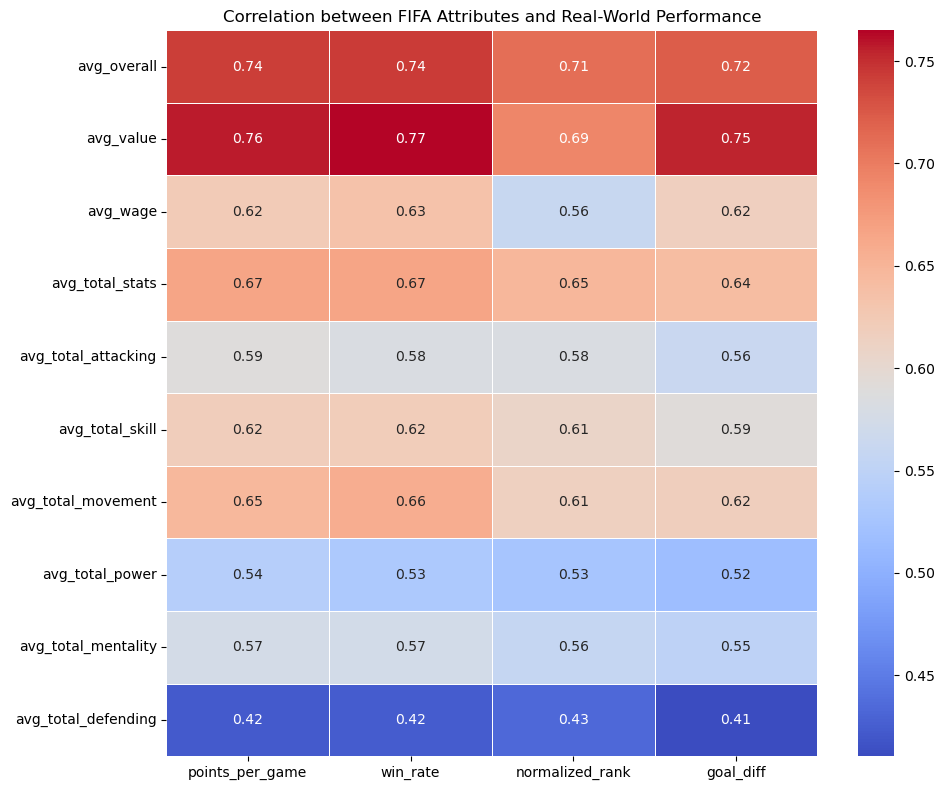

In [94]:
# 4. Visualize the correlations
plt.figure(figsize=(10, 8))
sns.heatmap(fifa_perf_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation between FIFA Attributes and Real-World Performance")
plt.tight_layout()
plt.show()

In [95]:
X = merged_df[fifa_cols]
X = sm.add_constant(X)
y = merged_df["points_per_game"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        points_per_game   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     62.47
Date:                Sat, 29 Nov 2025   Prob (F-statistic):           4.51e-71
Time:                        16:09:18   Log-Likelihood:                -37.913
No. Observations:                 353   AIC:                             97.83
Df Residuals:                     342   BIC:                             140.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -3.5432    

To quantify how well FIFA attributes explain real-world team performance, we fit a multivariable OLS regression with points per game as the outcome and team-level FIFA features as predictors. The model achieved an R² of 0.65 (adj. R² ≈ 0.64), indicating that FIFA-based attributes collectively explain roughly two-thirds of the variation in points per game across teams and seasons. Among the predictors, average squad value (avg_value) is a strong and highly significant positive predictor (p < 0.001), confirming that more expensive squads tend to earn more points even after accounting for other ratings. Aggregate quality captured by avg_total_stats also shows a significant positive association (p ≈ 0.009), suggesting that broader overall stat totals carry additional signal beyond value alone. In contrast, average wage (avg_wage) enters with a significant negative coefficient (p ≈ 0.001), and avg_total_power and avg_total_mentality also show significant negative effects; given the extremely large condition number (≈ 8.6×10⁸), these counterintuitive signs are best interpreted as artifacts of multicollinearity among overlapping FIFA attributes rather than evidence that higher power or mentality “hurt” performance. Several other components (e.g., avg_overall, avg_total_attacking, avg_total_defending) are not individually significant once the full set of correlated features is included. Overall, the regression supports the conclusion that squad value and broad total-stat measures are the most informative FIFA-derived predictors of real-world success, while many finer-grained attributes are highly redundant and should be interpreted cautiously in a multivariate setting.

### Random Forest Feature Importance (Robustness Check)

As a complementary, non-linear model, we also fit a Random Forest regressor to predict points per game from the full set of FIFA-derived team attributes and examine its feature importances. This provides a model-based ranking of which FIFA characteristics are most useful for prediction, and serves as a robustness check alongside the linear regression results.


Random Forest Feature Importances (predicting points_per_game):
               feature  importance
0            avg_value    0.719092
1             avg_wage    0.052470
2          avg_overall    0.041458
3   avg_total_movement    0.036123
4  avg_total_defending    0.032160
5  avg_total_attacking    0.030301
6  avg_total_mentality    0.026668
7      avg_total_power    0.022904
8      avg_total_skill    0.020036
9      avg_total_stats    0.018788


/var/folders/cl/4ndfg5191d74xd8pclttf16w0000gn/T/ipykernel_11869/1927580285.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=rf_importance, palette="viridis")


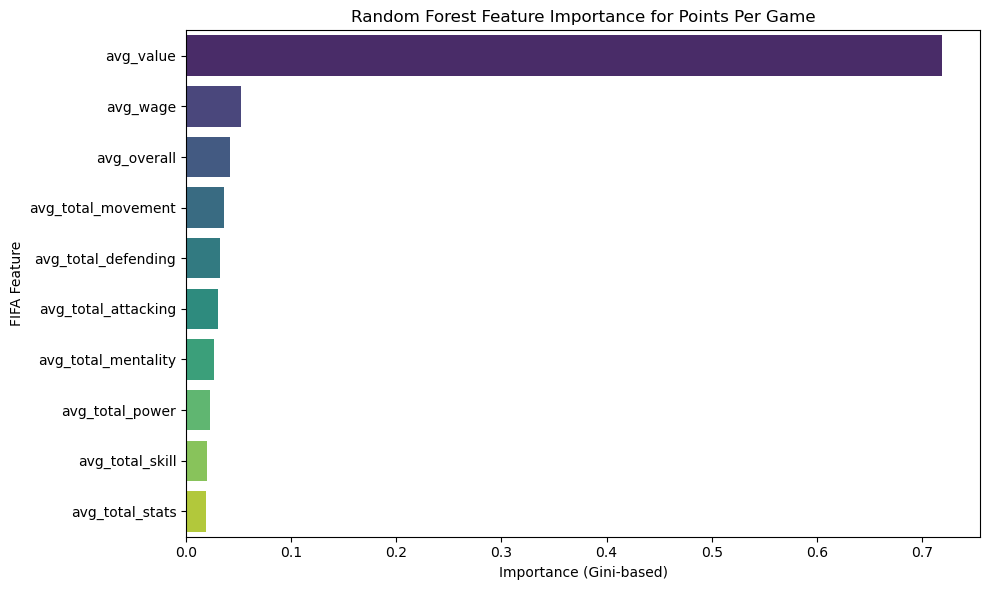

In [104]:
from sklearn.ensemble import RandomForestRegressor

# Use the same FIFA features as in the correlation/regression analysis
X_rf = merged_df[fifa_cols]
y_rf = merged_df["points_per_game"]

rf_model = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1)
rf_model.fit(X_rf, y_rf)

# Build a feature importance table
rf_importance = pd.DataFrame({
    "feature": fifa_cols,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False).reset_index(drop=True)

print("Random Forest Feature Importances (predicting points_per_game):")
print(rf_importance)

# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=rf_importance, palette="viridis")
plt.xlabel("Importance (Gini-based)")
plt.ylabel("FIFA Feature")
plt.title("Random Forest Feature Importance for Points Per Game")
plt.tight_layout()
plt.show()


#### Research Question 2

In [96]:
edition_map = {
    2020: "FIFA 21",
    2021: "FIFA 22",
    2022: "FIFA 23",
    2023: "FIFA 24",
    2024: "FC 25",
}

merged_df["edition"] = merged_df["season"].map(edition_map)
df_edition = merged_df[merged_df["edition"].notna()].copy()

In [97]:
perf_cols = ["points_per_game", "win_rate", "normalized_rank", "goal_diff"]
fifa_col = "avg_overall"  # you can try avg_value as well
rows = []

for ed, grp in df_edition.groupby("edition"):
    row = {"edition": ed}
    for col in perf_cols:
        row[col] = grp[fifa_col].corr(grp[col])
    rows.append(row)

corr_by_edition = pd.DataFrame(rows).sort_values("edition")
print(corr_by_edition)

   edition  points_per_game  win_rate  normalized_rank  goal_diff
0    FC 25         0.768910  0.769813         0.750498   0.752761
1  FIFA 22         0.794959  0.771174         0.751936   0.763233
2  FIFA 23         0.692764  0.715282         0.680501   0.683660
3  FIFA 24         0.711497  0.718745         0.648207   0.698138


In [98]:
order = ["FIFA 22", "FIFA 23", "FIFA 24", "FC 25"]

corr_by_edition["edition"] = pd.Categorical(
    corr_by_edition["edition"], 
    categories=order,
    ordered=True
)

corr_by_edition = corr_by_edition.sort_values("edition")

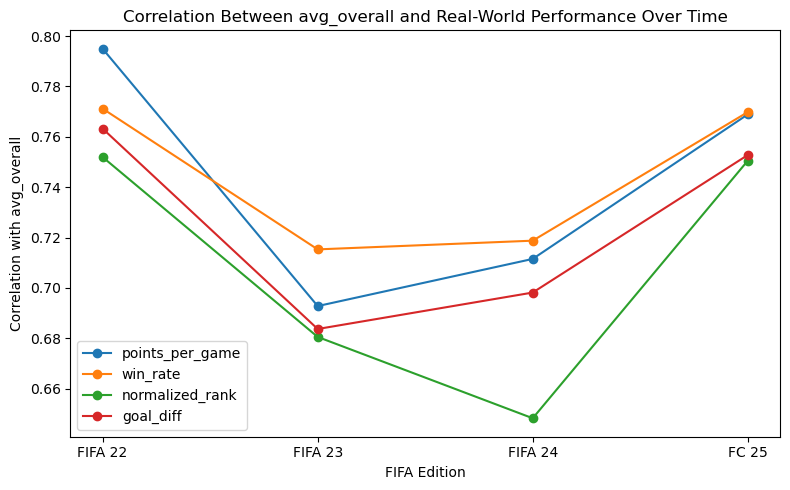

In [99]:
plt.figure(figsize=(8, 5))

for col in perf_cols:
    plt.plot(
        corr_by_edition["edition"],
        corr_by_edition[col],
        marker="o",
        label=col
    )

plt.xlabel("FIFA Edition")
plt.ylabel(f"Correlation with {fifa_col}")
plt.title(f"Correlation Between {fifa_col} and Real-World Performance Over Time")
plt.legend()
plt.tight_layout()
plt.show()

The figure presents the correlation between average FIFA team overall rating and several real-world performance metrics—points per game, win rate, normalized league rank, and goal difference—across editions FIFA 22 through FC 25. Overall, the results show that FIFA ratings are consistently strong predictors of team success, with correlations generally falling between 0.68 and 0.79. The alignment between ratings and real performance is highest in FIFA 22, where all metrics peak, indicating particularly strong realism in that edition’s rating system. Correlations decline noticeably in FIFA 23, reaching their lowest levels across all metrics, before stabilizing or slightly improving in FIFA 24. By FC 25, correlations rise again for all four performance measures, nearly returning to FIFA 22 levels. This U-shaped trend suggests that the accuracy of the rating formula dipped in the mid-cycle period (FIFA 23–24) but rebounded in the latest edition. Importantly, despite these fluctuations, correlations remain consistently high across all years, indicating that FIFA ratings have been robustly and reliably aligned with real-world team performance throughout the entire 2022–2025 period.

In [100]:
import statsmodels.api as sm

fifa_predictors = ["avg_overall", "avg_value"]  # or more, but keep it small

r2_rows = []

for ed, grp in df_edition.groupby("edition"):
    X = grp[fifa_predictors]
    X = sm.add_constant(X)
    y = grp["points_per_game"]

    model = sm.OLS(y, X).fit()
    r2_rows.append({"edition": ed, "R2_points_per_game": model.rsquared})

r2_by_edition = pd.DataFrame(r2_rows).sort_values("edition")
print(r2_by_edition)

   edition  R2_points_per_game
0    FC 25            0.627478
1  FIFA 22            0.747899
2  FIFA 23            0.503804
3  FIFA 24            0.573355


In [101]:
r2_by_edition["edition"] = pd.Categorical(
    r2_by_edition["edition"], 
    categories=order,
    ordered=True
)
r2_by_edition.sort_values("edition", inplace=True)

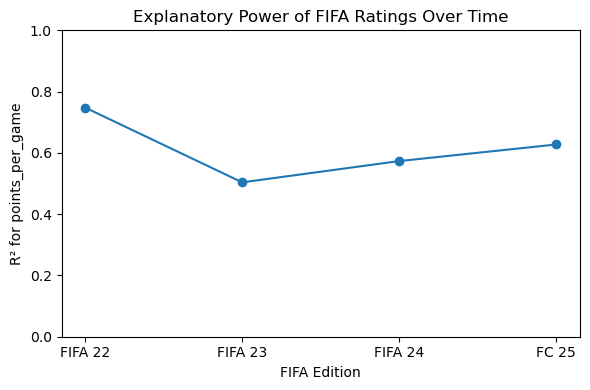

In [102]:
plt.figure(figsize=(6,4))
plt.plot(r2_by_edition["edition"], r2_by_edition["R2_points_per_game"], marker="o")
plt.ylim(0, 1)
plt.xlabel("FIFA Edition")
plt.ylabel("R² for points_per_game")
plt.title("Explanatory Power of FIFA Ratings Over Time")
plt.tight_layout()
plt.show()

To quantify how well FIFA ratings jointly explain real-world performance in each edition, we fit separate linear regressions of points per game on average overall rating and average squad value for FIFA 22 through FC 25 and recorded the resulting R² values. The models achieve good explanatory power in all editions, with R² values ranging from roughly 0.50 to 0.75, indicating that just these two FIFA-derived features account for about half to three-quarters of the variation in team points per game. The explanatory power is highest in FIFA 22 (R² ≈ 0.75), drops noticeably in FIFA 23 (R² ≈ 0.50), and then partially recovers in FIFA 24 and FC 25 (R² ≈ 0.57 and 0.62, respectively). This pattern mirrors the correlation analysis and suggests that while there is some year-to-year fluctuation in how tightly ratings align with outcomes, FIFA ratings have remained consistently informative predictors of team performance, with no evidence of a systematic breakdown in realism over time and a modest rebound in the most recent edition.